# HABSlib + BrainOS : 105
In this fifth notebook, we will learn the workflow of how to search for EEG biomarkers using the BrainOS APIs.

### What is a biomarker
A **biomarker** is a measurable indicator of some biological state or condition ([Wikipedia](https://en.wikipedia.org/wiki/Biomarker)). They can be **predictive**, when they serve as a method of predicting (often clinical) outcomes, **diagnostic**, when they serve a role in narrowing down diagnosis, or **prognostic**, when they provide information about the patients overall outcome.      
More practically, to build a biomarker, you need to find indicative features of the biological state you want to detect. A **feature** is an individual measurable property or characteristic of a phenomenon ([Wikipedia](https://en.wikipedia.org/wiki/Feature_(machine_learning))). Often, just one feature will not be enough to reliably identify the target biological state. This is why you need to explore the feature space.

### How we do it
For this session, we will use the HABSlib EEG simulator to create an EEG signal of known features representing a biological state (like *"drowsy"*). Then we will use the BrainOS API to
- extract a whole set of features,
- assess their significance,
- and rank those that are more indicative of the EEG state.      

At the end of this procedure, we should have a better understanding of the relevant features for our phenomenon.

Please, refer to the documentation of [HABSlib](https://olocufier.github.io/HABSlib/) for further details.

In [1]:
import nest_asyncio # to allow HABSlib to run async in a Jupyter notebook
nest_asyncio.apply()

import HABSlib as hb
from datetime import datetime
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt


/Users/do/neuromodulation/nm/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Login
As usual, the first thing to do to start a session with the HABS BrainOS is to handshake.

In [2]:
# hb.handshake(base_url="http://135.237.144.125/", user_id='8d60e8693a9560ee57e8eba3')
hb.handshake(base_url="http://0.0.0.0/", user_id='8d60e8693a9560ee57e8eba3')


       HUMAN        AUGMENTED        BRAIN         SYSTEMS     
   ----------------------------------------------------------- 
   ▒▒▒▒     ▒▒▒▒     ░▒▒▒▒▒░     ▒▒▒▒▒▒▒▒▒▒▒▒░   ░▒▒▒▒▒▒▒▒▒░   
   ▒▒▒▒     ▒▒▒▒    ░▒▒▒▒▒▒▒░             ░▒▒▒▒ ░▒▒▒░     ░▒░  
   ▒▒▒▒▒▒▒▒▒▒▒▒▒   ░▒▒▒▒ ▒▒▒▒░   ▒▒▒▒▒▒▒▒▒▒▒▒▒   ░▒▒▒▒▒▒▒▒▒░   
   ▒▒▒▒     ▒▒▒▒  ░▒▒▒▒   ▒▒▒▒░  ▒▒▒▒     ░▒▒▒▒ ░▒░     ░▒▒▒░  
   ▒▒▒▒     ▒▒▒▒ ░▒▒▒▒     ▒▒▒▒░ ▒▒▒▒▒▒▒▒▒▒▒▒░   ░▒▒▒▒▒▒▒▒▒░   
   ----------------------------------------------------------- 
   version: 0.1.41

Handshake (RSA) successful.
Handshake (AES) successful.


True

## Synthetic data for drowsiness
Drowsiness is the feeling of being sleepy. It is often characterized in the EEG community with relatively higher power spectral amplitudes in the Delta and Theta bands ([Lechat et al. 2022](https://pubmed.ncbi.nlm.nih.gov/35554584/), [Xavier et al. 2020](https://pubmed.ncbi.nlm.nih.gov/32515890/)). We take these features as examples and not as actually or fully identifying drowsiness.

With the HABSlib EEG simulator, we can easily introduce relative power amplitudes for the different bands.

To simulate a protocol in which a baseline EEG is acquired for 5 seconds and it is followed by 15 seconds of focused state, we will use a sequence of presets.     
The dummy preset `relaxed` is characterized by relativey high alpha band amplitude (Delta=0.2, Theta=0.2, Alpha=0.7, Beta=0.3, Gamma=0.2; these values are relative to the overall amplitude computed by the HABSlib dummy EEG generator).     
The dummy preset `focus` is characterized by relativey high beta band amplitude (Delta=0.1, Theta=0.1, Alpha=0.5, Beta=0.8, Gamma=0.4).     

In [3]:
# Acquire synthetic EEG data
session_id = hb.acquire_send_raw(
    user_id='8d60e8693a9560ee57e8eba3', 
    date=datetime.today().strftime('%Y-%m-%d %H:%M:%S'), 
    board="SYNTHETIC", 
    extra={
        "eeg_channels": 16,
        "sampling_rate": 250,
        "noise": 1,
        "artifacts": 0.01,
        "modulation_type": 'random',
        "power_law_slope": 0.8,
        "sequence": [("relaxed",5),("alert",15)]
    },
    serial_number="", 
    stream_duration=20, 
    buffer_duration=5
)

Session successfully created.

Session initialized. You can visualize it here:
  https://habs.ai/live.html?session_id=66bb8658d930d80ef5873f25 

{'user_id': '8d60e8693a9560ee57e8eba3', 'session_date': '2024-08-13 18:14:16', 'session_type': '', 'session_tags': []}
Metadata validation successful!
Connecting to the headset...
Headset connected successfully!
....
Stopping data streaming...
Releasing session...


In [4]:
# Retrieve the data for the session
results = hb.get_data_by_session(user_id='8d60e8693a9560ee57e8eba3', session_id=session_id)
eeg_data = np.array(results)

Retrieved data successfully.


#### Baseline ('relaxed') PSD

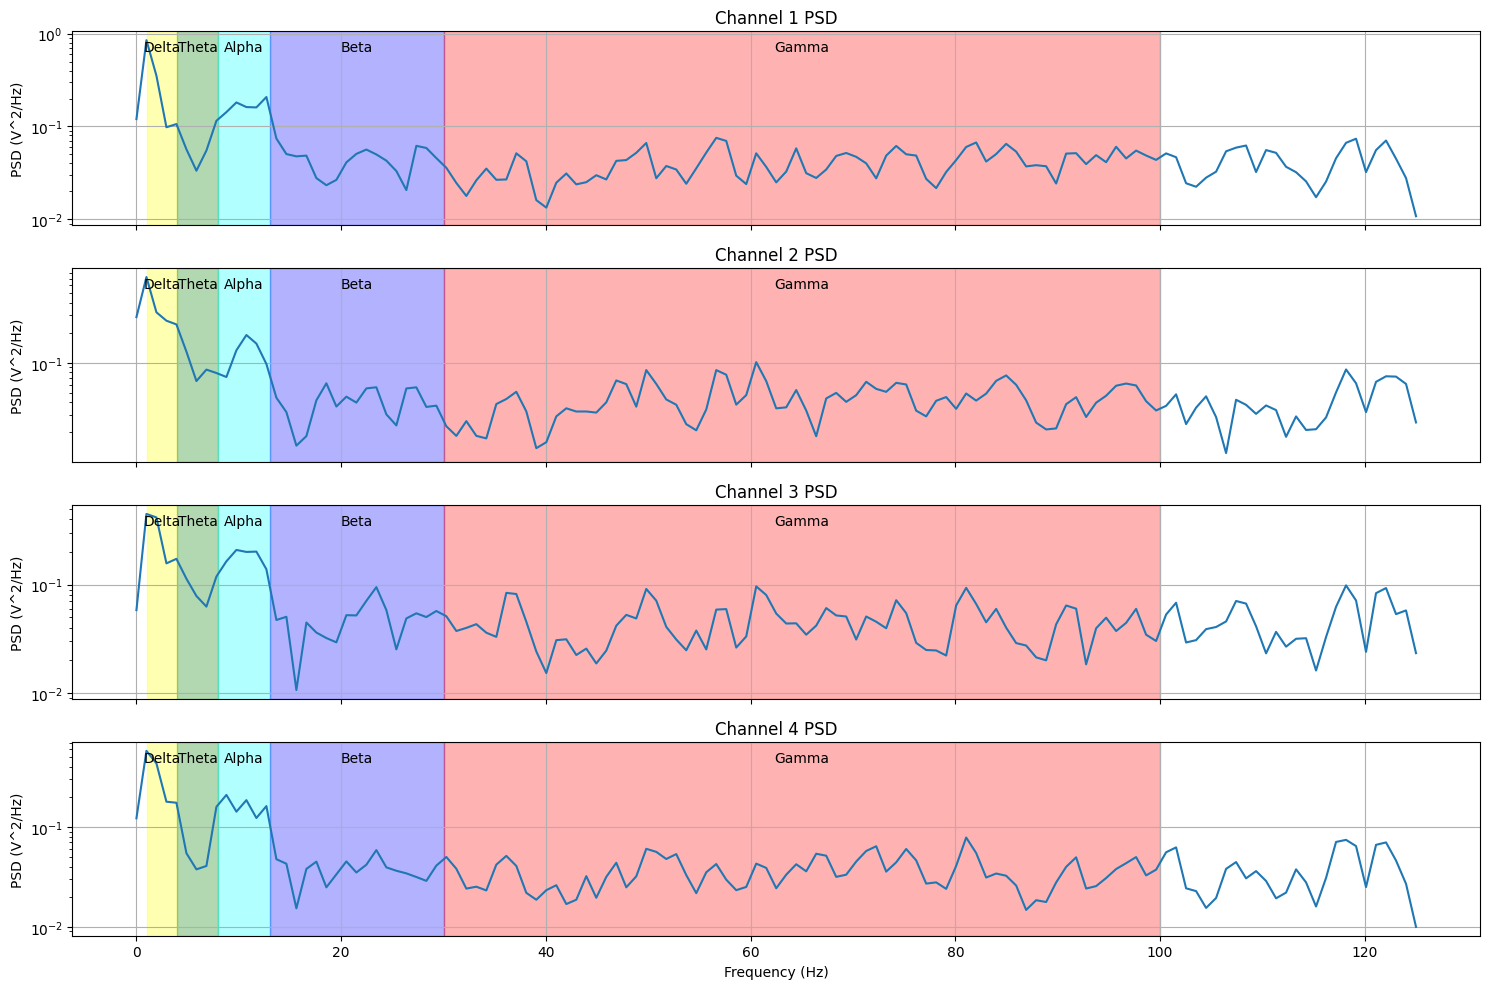

In [5]:
samples_per_second = 250
num_channels=4 # how many you want to plot

# Define frequency bands
bands = {
    'Delta': (1, 4, 'yellow'),
    'Theta': (4, 8, 'green'),
    'Alpha': (8, 13, 'cyan'),
    'Beta': (13, 30, 'blue'),
    'Gamma': (30, 100, 'red')
}

fig, axes = plt.subplots(num_channels, 1, figsize=(15, 10), sharex=True)

for i in range(num_channels):
    # Plotting the PSD
    freqs, psd = signal.welch(eeg_data[i][:1250], fs=samples_per_second)
    axes[i].semilogy(freqs, psd)
    axes[i].set_title(f'Channel {i+1} PSD')
    axes[i].set_ylabel('PSD (V^2/Hz)')
    axes[i].grid(True)
    # Highlighting frequency bands
    for band, (low, high,col) in bands.items():
        axes[i].axvspan(low, high, color=col, alpha=0.3)
        axes[i].text((low + high) / 2, max(psd), band, horizontalalignment='center', verticalalignment='top')

axes[-1].set_xlabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

#### Task ('focus') PSD

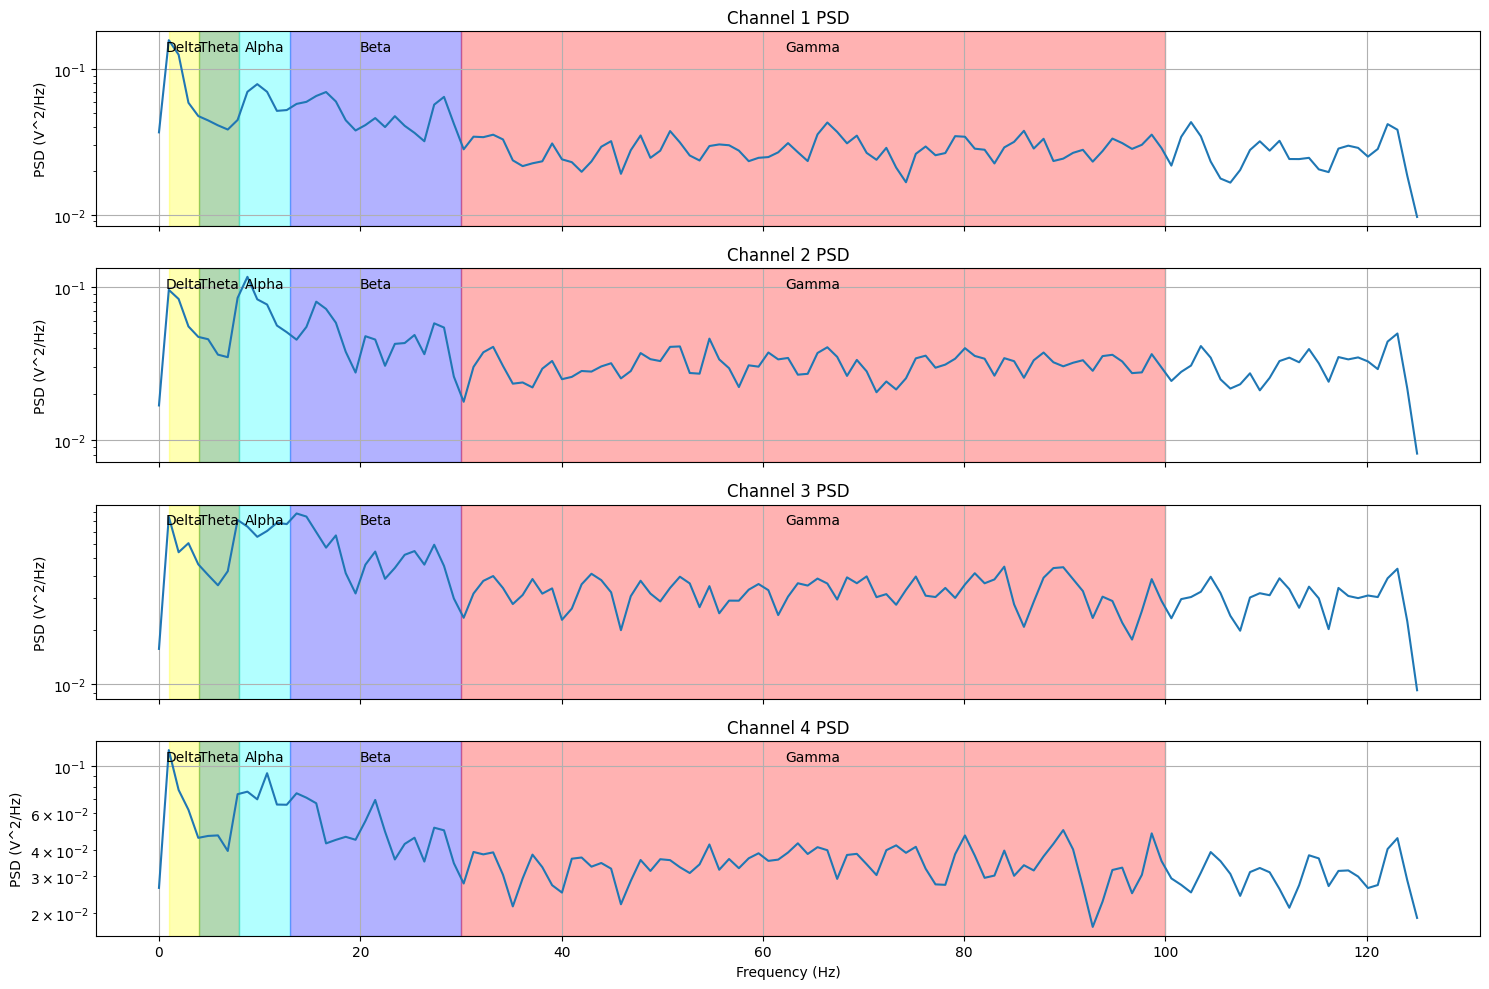

In [6]:
samples_per_second = 250
num_channels=4 # how many you want to plot

# Define frequency bands
bands = {
    'Delta': (1, 4, 'yellow'),
    'Theta': (4, 8, 'green'),
    'Alpha': (8, 13, 'cyan'),
    'Beta': (13, 30, 'blue'),
    'Gamma': (30, 100, 'red')
}

fig, axes = plt.subplots(num_channels, 1, figsize=(15, 10), sharex=True)

for i in range(num_channels):
    # Plotting the PSD
    freqs, psd = signal.welch(eeg_data[i][1250:], fs=samples_per_second)
    axes[i].semilogy(freqs, psd)
    axes[i].set_title(f'Channel {i+1} PSD')
    axes[i].set_ylabel('PSD (V^2/Hz)')
    axes[i].grid(True)
    # Highlighting frequency bands
    for band, (low, high,col) in bands.items():
        axes[i].axvspan(low, high, color=col, alpha=0.3)
        axes[i].text((low + high) / 2, max(psd), band, horizontalalignment='center', verticalalignment='top')

axes[-1].set_xlabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

### Tag session data as 'baseline' or 'target'
The two conditions above will be the bases for our analysis. We tag them to be more easily accessed in the analysis steps below.      
We use the BrainOS built-in tagging endpoint.

In [7]:
# tagging 'baseline' interval

# tagging 'target' interval


## Feature extraction and assessment
In this session, we will iterate over the data, directly on the server, using BrainOS feature extraction APIs.     

We will use the API pipeline `/filtering/artifact/<feature>` for some available features:
- mean
- std
- var
- kurtosis
- skew
- delta
- theta
- alpha
- beta
- gamma
- zerocrossing
- hjorthmobility
- hjorthcomplexity
- entropy
- fractaldim
- hurst
- selfaffinity

We will extract the same feature for the `baseline` tagged interval and the `target` interval. Then we will assess the significance of the current feature by looking, first, at the standard deviation and percentile of its value during the `target` interval with respect to the `baseline` interval.      
For example, we will label values as significant if the `target` value is more than two standard deviations above the mean of the `baseline` interval.

We will store these values in a dictionary and plot a summary at the end.

In [8]:
# Feature map
features = ['mean','std','var','kurtosis', 'skew', 
            'delta', 'theta', 'alpha', 'beta', 'gamma', 
            'zerocrossings', 'hjorthmobility', 'hjorthcomplexity', 'entropy', 'hurst']
            # out, for the moment:
            # 'correlatedim', 'fractaldim', 'selfaffinity', 'asymmetry', 'correlation', 'phaselocking'

# Step 1: Iterate over the features
feature_results = {}

# parameters for the filtering
b_notch, a_notch = signal.iirnotch(50., 2.0, 250)
sos = signal.butter(10, [1, 40], 'bandpass', fs=250, output='sos')

# Step 2: Grid search to generate synthetic EEG and calculate SSR
for i, feature in enumerate(features):
        print(f"\n\n---------------------------\nFeature {i}: {feature}\n")
        
        # Step 3: Extract the feature
        _, processed_data = hb.process_session_pipe(
            pipeline=f"/filtering/artifact/{feature}",
            params={
                "filtering": {'a_notch': a_notch.tolist(),'b_notch': b_notch.tolist(),'sos': sos.tolist()},
                "artifact":{},
                f"{feature}":{'window':20} # data points
            },
            user_id='8d60e8693a9560ee57e8eba3', 
            existing_session_id = session_id,
            date=datetime.today().strftime('%Y-%m-%d %H:%M:%S'),
            session_type="Feature Extraction", 
            tags=[f"{feature}"]
        )
        processed_data = np.array(processed_data)
        print(processed_data.shape) 

        if i<10:
            processed_data = processed_data.mean(axis=1)
            
        processed_data = processed_data.flatten()

        print("processed_data:", processed_data)

        # Standard Deviation: Use the mean and standard deviation. 
        # For example, label values as significant if they are more than two standard deviations above the mean.

        



---------------------------
Feature 0: mean

{'user_id': '8d60e8693a9560ee57e8eba3', 'session_date': '2024-08-13 18:14:43', 'existing_session_id': '66bb8658d930d80ef5873f25', 'session_type': '[On 66bb8658d930d80ef5873f25]: Feature Extraction', 'session_tags': ['mean']}
Metadata validation successful!
Session successfully created.
(16, 250)
processed_data: [ 4.33703679e-04  1.89245587e-03  4.63742014e-03  3.98494961e-03
  1.45358131e-03  2.52695858e-03  1.87052487e-03 -1.84087590e-04
 -1.23164591e-03  2.31980624e-04 -4.29483389e-03  2.97660352e-05
 -4.47131621e-05  3.25236738e-03  3.60725984e-03 -3.77152611e-04]


---------------------------
Feature 1: std

{'user_id': '8d60e8693a9560ee57e8eba3', 'session_date': '2024-08-13 18:14:45', 'existing_session_id': '66bb8658d930d80ef5873f25', 'session_type': '[On 66bb8658d930d80ef5873f25]: Feature Extraction', 'session_tags': ['std']}
Metadata validation successful!
Session successfully created.
(16, 250)
processed_data: [1.04731379 1.0655754

## Evaluation

Now we have a reproducible measure of the range of noise and signal values within which the API is capable of extracting the beta content.

# Next steps
**Different Noise Types**: Instead of just increasing noise amplitude linearly, introduce different types of noise (e.g., white noise, pink noise, bursts of noise) and evaluate how these impact feature extraction.

**Multiple Runs per Condition**: For each combination of noise and feature amplitude, run multiple simulations to account for the stochastic nature of EEG generation and noise. Compute the average and standard deviation of the extracted feature content to get a more reliable assessment.

**Multi-Feature Analysis**: It would be valuable to simultaneously assess other extracted features (e.g., power in other bands, entropy) to see how noise affects the overall feature set.

**Benchmark Against Real Data**: Compare synthetic data with real EEG data under similar noise conditions. This would help ensure that the synthetic data accurately represents real-world scenarios.

**Time-Based Variation**: Instead of just looking at static EEG segments, analyze how the extraction performs over time if noise levels or alpha content change dynamically within the signal.